![image](google-header.png)

## **Google Search Analysis: EDA**


### **Recap...**
So...in the previous workbook we explored getting the data from Google...Cool! Lets take things a step further and see if we can start to understand the results, population, do some feature engineerings, and prepare to do some modeling in the next step.

## **Overview**
The following cells will do some data exploration, basic cleanup, some feature engineering, and then clustering and text analysis.

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

RAW_DATA = 'data'

#### **Import Data**

In [16]:
search_results = pd.read_csv(Path(RAW_DATA).joinpath('search_results.tsv'), delimiter='\t')
search_results.drop(columns=['mime','fileFormat','cacheId'], inplace=True)
search_results.head()

,title,link,displayLink,snippet,formattedUrl,pagemap
0,10 Turfway Park,https://www.espn.com/media/horse/RACE5_060325.pdf,www.espn.com,10 Turfway Park. LanesEnd-G2. 1 MILES (1:49 35...,https://www.espn.com/media/horse/RACE5_060325.pdf,"{'metatags': [{'moddate': 'D:20060323171220', ..."
1,"""i'd do anything"" official rules for applicant...",https://www.espn.com/eoe/doanything/IDA2_rules...,www.espn.com,"""I'd Do Anything"" is a reality/game show (the ...",https://www.espn.com/eoe/doanything/IDA2_rules...,"{'metatags': [{'moddate': ""D:20050217104133-08..."
2,critique of the freeh report: the rush to inju...,https://www.espn.com/pdf/2013/0210/espn_otl_FI...,www.espn.com,KING & SPALDING: FEBRUARY 2013. WICK SOLLERS. ...,https://www.espn.com/pdf/.../espn_otl_FINAL%20...,NaN
3,police wrote,https://www.espn.com/pdf/2015/0614/IanWalker_t...,www.espn.com,"Jun 14, 2015 ... Age : 22. Occupation/Vocation...",https://www.espn.com/pdf/2015/0614/IanWalker_t...,"{'metatags': [{'moddate': ""D:20150613140101-04..."
4,the police report states,https://www.espn.com/pdf/2015/0614/Perry_fight...,www.espn.com,"Jun 14, 2015 ... On April 13, 2014 at 2048 hou...",https://www.espn.com/pdf/2015/0614/Perry_fight...,{'cse_thumbnail': [{'src': 'https://encrypted-...


In [6]:
search_terms = pd.read_csv(Path(RAW_DATA).joinpath('search_terms.tsv'),delimiter='\t')
search_terms.head()

,totalResults,siteSearch,siteSearchFilter,fileType
0,399,espn.com,i,pdf


#### **Vecotrize Search Result Titles**
Perform very basic text processing for baseline KMeans application

In [37]:
# Get text snippets from search results dataframe
snippets_text = [*set(search_results['title'])]
print(snippets_text)
vectorizer = TfidfVectorizer(stop_words='english')

X = vectorizer.fit_transform(snippets_text)

['suit filed in federal court in North Carolina', '06 WST Thurs Mat Slack AP', 'Policy on Integrity of the Game & Enforcement of Competitive Rules', 'Goodell assured Specter', 'financial aspects', 'These results are unofficial from the Greeley Stampede, June 27 ...', 'The following are unofficial Wrangler ProRodeo Tour standings as of ...', 'Colorado Springs, Colo.', '9 Colonial Downs', 'Media Delivery Specifications Appendix', 'Bounty', 'To: Nicole Noren, Tom Farrey ESPN Outside the Lines From: Chad ...', 'List of 76 postsecondary institutions that have pending Title IX ...', 'critique of the freeh report: the rush to injustice regarding joe paterno', 'YEAR: 2010 Injured body part Age Gender Description All parts of ...', 'These results are unofficial from the National Western (Denver) Jan ...', 'Woodbine', 'PDF: Tom Brady appeal transcript', 'These results are unofficial from the California Rodeo Salinas, July ...', 'League football activities', 'BCS media guide', 'Commercial Guideli

#### **Determine KMeans Clusters**

In [38]:
inertias = []

KMEANS_MAX = range(2,30,2)

for k in KMEANS_MAX:
    model = KMeans(n_clusters=k, init='k-means++', max_iter=100)
    model.fit_predict(X)
    inertias.append(model.inertia_)

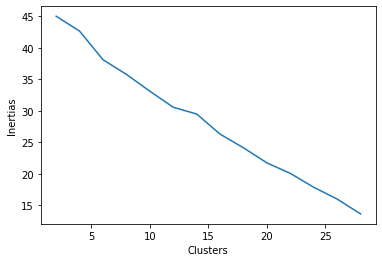

In [19]:
model_selection = pd.DataFrame({'Inertias': inertias, 'Clusters': KMEANS_MAX})
sns.lineplot(x=model_selection['Clusters'], y=model_selection['Inertias'])

##### **KMeans Interpretation**

The above Inertia plot is not very useful. Even with expansion of clusters the model is having trouble finding clusters of similarities. It is most likely due to very basic preprocessing step, or the fact that we had a very specific search, there truly is only "1" cluster. To improve the clustering, I would spend greater time on text pre-processing and introduce some other topics to see how the cluster performs. 

Specifically, the numbers 19 seem to be detracting from clustering ability since it appears in almost every title.

#### **Model Selection**
As noted above, there is not a elbow in above inertia plot indicating difficulty in clustering these article titles. For this example case, we wil go with 15 clusters to get good performance and prove further clustering techniques

In [20]:
model = KMeans(n_clusters=15, init='k-means++', max_iter=100)
model.fit_predict(X)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()

clusters_tmp = []
for i in range(0,15):
    cluster = {'cluster': 'Cluster '+str(i),
               'keywords': [terms[ind] for ind in order_centroids[i, :5]]}
    clusters_tmp.append(cluster)
    
keywords = pd.DataFrame(clusters_tmp)
keywords = keywords.explode('keywords')
keywords.head(50)

,cluster,keywords
0,Cluster 0,standings
0,Cluster 0,colonial
0,Cluster 0,prca
0,Cluster 0,sam
0,Cluster 0,nationalconvention
1,Cluster 1,football
1,Cluster 1,league
1,Cluster 1,activities
1,Cluster 1,mascot
1,Cluster 1,psychological
